In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler, Normalizer


pd.set_option('display.max_columns', None)

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']
path = "../data/"

In [3]:
def plot_learning_curve(sizes,train,val):
    train_scores_mean = np.mean(train, axis=1)
    train_scores_std = np.std(train, axis=1)
    val_scores_mean = np.mean(val, axis=1)
    val_scores_std = np.std(val, axis=1)

    _, axes = plt.subplots(1,)
    axes.grid()
    axes.fill_between(
        sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.fill_between(
        sizes,
        val_scores_mean - val_scores_std,
        val_scores_mean + val_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.plot(
        sizes, train_scores_mean, "o-", color="g", label="Training score"
    )
    axes.plot(
        sizes, val_scores_mean, "o-", color="r", label="Cross-validation score"
    )
    axes.legend(loc="best")
    
    plt.xlabel("Training Sizes")
    
    plt.show()
    return 

## Developing a Classifier in Complete Dataset

In [4]:
# Obtained from Optimization
min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2P8 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"DB5.csv")
DB2 = DB2P8[DB5.columns] # Because DB2P8 has more columns than DB5

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[-1]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1

print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

23.45% of the data decreased alpha_R
76.55% of the data did not decrease alpha_R


Class distribution can be considered almost severly skewed.

In [5]:
features = ['TAUTH','NEL','RGEO','BT','RHOSTAR','NUSTAR','BETASTAR','PECRH', 'PICRH','QCYL5']
DB5.columns

Index(['ind', 'id', 'label', 'PHASE', 'TOK', 'IP', 'BT', 'NEL', 'PLTH', 'RGEO',
       'KAREA', 'EPS', 'MEFF', 'TAUTH', 'DATE', 'SHOT', 'TIME', 'Q95', 'ZEFF',
       'AMIN', 'VOL', 'POHM', 'PNBI', 'DWDIA', 'DWMHD', 'PICRH', 'PECRH', 'PL',
       'PFLOSS', 'TAV', 'LCOULOMB', 'QCYL5', 'TAUBOHM', 'RHOSTAR', 'BETASTAR',
       'NUSTAR', 'OMEGACYCL'],
      dtype='object')

### On the Metrics: What do you want to predict? 

Notes on [[Jason Browniee, 2020]](https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/)

* **PROBABILITIES**
    * If only probabilities needed: Brier Score
    * **With class label, if minority class is more important: PR AUC**
    * With class label, if both classes are equally important: ROC AUC
* **CLASS LABELS**
    * Both classes are euqally important: G-Mean
        * Not so severely skewed data: Accuracy
    * If minority class is more important: 
        * Both false positive and false negative are equally costly: F1 Score
        * False positives (minority) are more costly: F0.5 Score
        * False negatives (majority) are more costly: F2 Score
        
### Spot-Check on ML Algorithms


1. Linear Algorithms
2. Nonlinear Algorithms
3. Ensemble Algorthms
4. **Data Sampling Algorithms**
5. **One-Class Algorithms** (specialized on severely imbalanced datasets)

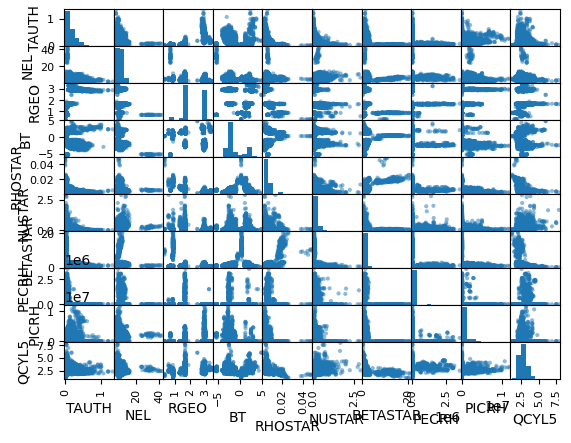

In [6]:
pd.plotting.scatter_matrix( DB5[features]);

### BINARY LOGISTIC REGRESSION

In [7]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve

n_folds = 10
cv = StratifiedKFold(n_splits=n_folds)

X = DB5[features].to_numpy()
y = DB5[["label"]].to_numpy().reshape(-1)

In [8]:
# Creating Pipeline

preprocessing = Pipeline([('StandardScaler',StandardScaler())])  
classifier = Pipeline([('clf', LogisticRegression(max_iter=5000))]) 

pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', classifier)])

param_grid = {
    'classifier__clf__C' : [0.1, 1, 10, 100],
}

# define GridSearchCV object
gridsearch = GridSearchCV(pipe, param_grid, n_jobs=4, cv=cv, verbose=5, 
                          return_train_score=True)

In [9]:
gridsearch.fit(X,y)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('StandardScaler',
                                                         StandardScaler())])),
                                       ('classifier',
                                        Pipeline(steps=[('clf',
                                                         LogisticRegression(max_iter=5000))]))]),
             n_jobs=4, param_grid={'classifier__clf__C': [0.1, 1, 10, 100]},
             return_train_score=True, verbose=5)

In [14]:
results = gridsearch.cv_results_
train_score = results['mean_train_score'][gridsearch.best_index_]
validation_score = results['mean_test_score'][gridsearch.best_index_]

print('Average training accuracy across folds: {:.3}'.format(train_score))
print('Average validation accuracy across folds: {:.3}'.format(validation_score))

print(gridsearch.best_params_)

Average training accuracy across folds: 0.795
Average validation accuracy across folds: 0.738
{'classifier__clf__C': 10}
[CV 1/10] END classifier__clf__C=0.1;, score=(train=0.787, test=0.781) total time=   0.0s
[CV 6/10] END classifier__clf__C=0.1;, score=(train=0.815, test=0.752) total time=   0.0s
[CV 9/10] END classifier__clf__C=0.1;, score=(train=0.790, test=0.778) total time=   0.0s
[CV 4/10] END classifier__clf__C=1;, score=(train=0.797, test=0.432) total time=   0.0s
[CV 5/10] END classifier__clf__C=1;, score=(train=0.774, test=0.861) total time=   0.0s
[CV 9/10] END classifier__clf__C=1;, score=(train=0.789, test=0.779) total time=   0.0s
[CV 3/10] END classifier__clf__C=10;, score=(train=0.789, test=0.803) total time=   0.0s
[CV 1/10] END classifier__clf__C=100;, score=(train=0.787, test=0.780) total time=   0.0s
[CV 2/10] END classifier__clf__C=100;, score=(train=0.815, test=0.768) total time=   0.0s
[CV 7/10] END classifier__clf__C=100;, score=(train=0.792, test=0.770) total

In [11]:
splits = ['split'+str(idx) for idx in range(n_folds)]
train_names = [st+'_train_score' for st in splits]
val_names = [st+'_test_score' for st in splits]
for idx in range(n_folds):
    print('Fold ',idx,': ')
    dum = results[train_names[idx]][0]
    print('Train score: {:.3}'.format(dum))
    dum = results[val_names[idx]][0]
    print('Validation score: {:.3}'.format(dum))

Fold  0 : 
Train score: 0.787
Validation score: 0.781
Fold  1 : 
Train score: 0.813
Validation score: 0.772
Fold  2 : 
Train score: 0.79
Validation score: 0.795
Fold  3 : 
Train score: 0.797
Validation score: 0.429
Fold  4 : 
Train score: 0.775
Validation score: 0.861
Fold  5 : 
Train score: 0.815
Validation score: 0.752
Fold  6 : 
Train score: 0.792
Validation score: 0.771
Fold  7 : 
Train score: 0.791
Validation score: 0.779
Fold  8 : 
Train score: 0.79
Validation score: 0.778
Fold  9 : 
Train score: 0.796
Validation score: 0.661


In [12]:
# extract best model from gridsearch object

best_model = gridsearch.best_estimator_

train_sizes, train_scores, val_scores = learning_curve(best_model,X,y, cv=cv, n_jobs=4, verbose=5)

[learning_curve] Training set sizes: [ 562 1828 3094 4360 5626]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  50 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done  18 out of  50 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  29 out of  50 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  40 out of  50 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.3s finished


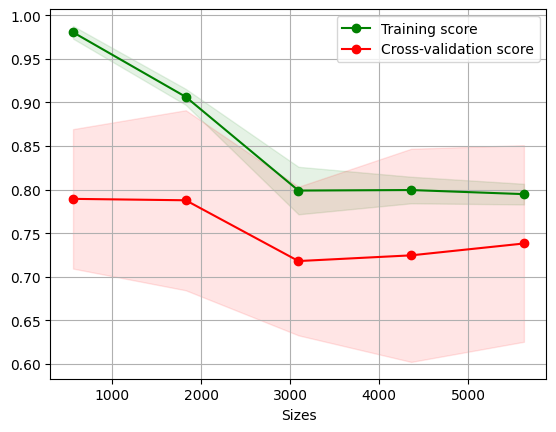

In [13]:
# Plot learning curve

mean_std_tra = round(np.mean(np.std(train_scores, axis=1)),3)
mean_std_val = round(np.mean(np.std(val_scores, axis=1)),3)

plot_learning_curve(train_sizes, train_scores, val_scores)